In [1]:
import os
import sys
import pandas as pd
import numpy as np
import yaml
import re
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib import rcParams
import matplotlib.ticker as ticker


import oemof.solph as solph
import oemof.outputlib as outputlib

sys.path.append(os.path.dirname('../src'))
sys.path.append(os.path.dirname('../src/helpers'))
from src import plot as pp

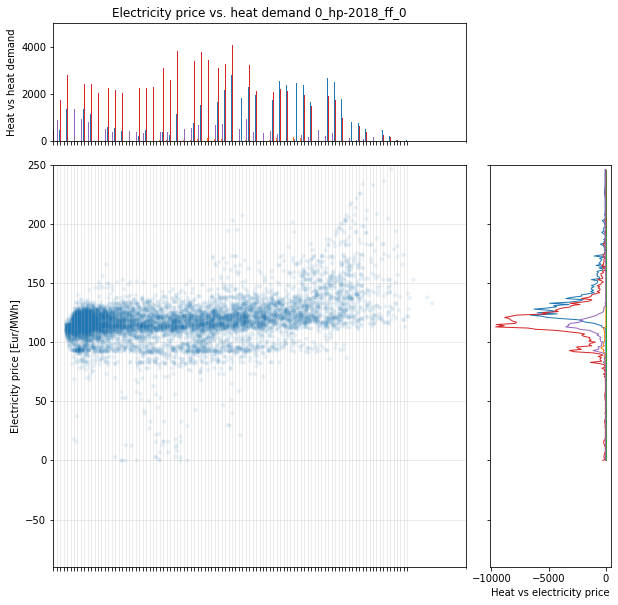

In [2]:
timeseries = pd.read_csv('/home/jann/Desktop/repos/model_development/System_B/Model_2/results/production_run/data_postprocessed/0_hp-2018_ff_0/timeseries/results_timeseries.csv',
                                 header=[0,1,2], index_col=0, parse_dates=True)

label = '0_hp-2018_ff_0'
results_dir = '/home/jann/Desktop/repos/model_development/System_B/Model_2/results/production_run'
energysystem = solph.EnergySystem()
energysystem.restore(dpath=os.path.join(results_dir, 'optimisation_results'), filename=f'{label}_es.dump')

param = outputlib.processing.convert_keys_to_strings(energysystem.results['Param'])
price_el = param['source_electricity', 'bus_el_import']['sequences']


with open(os.path.join('/home/jann/Desktop/repos/model_development/System_B/Model_2/experiment_configs/color_dict.yml'), 'r') as color_file:
    color_dict = yaml.load(color_file)
    
with open(os.path.join('/home/jann/Desktop/repos/model_development/System_B/Model_2/experiment_configs/label_dict.yml'), 'r') as label_file:
    label_dict = yaml.load(label_file)

pp.plot_demand_heat_vs_price_el(timeseries, price_el,
                                color_dict, label,
                                'pics/demand_heat_cs_price_el.pdf')

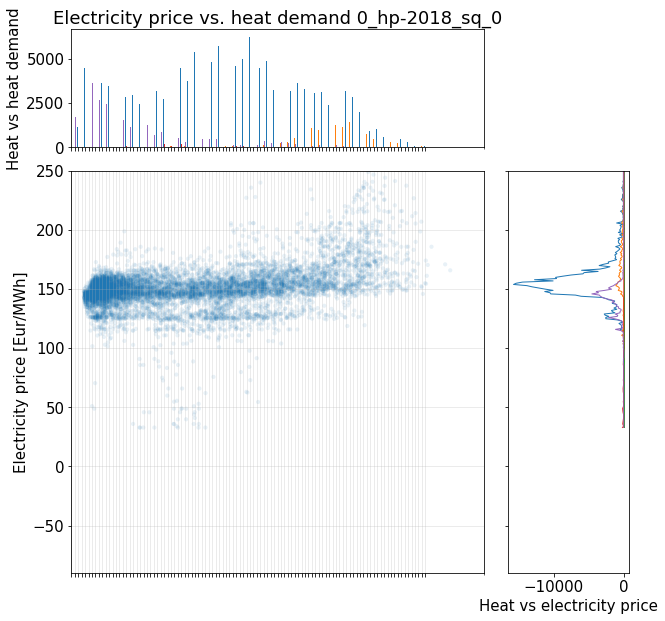

In [483]:
timeseries = pd.read_csv('/home/jann/Desktop/repos/model_development/System_B/Model_2/results/production_run/data_postprocessed/0_hp-2018_sq_0/timeseries/results_timeseries.csv',
                                 header=[0,1,2], index_col=0, parse_dates=True)

label = '0_hp-2018_sq_0'
results_dir = '/home/jann/Desktop/repos/model_development/System_B/Model_2/results/production_run'
energysystem = solph.EnergySystem()
energysystem.restore(dpath=os.path.join(results_dir, 'optimisation_results'), filename=f'{label}_es.dump')

param = outputlib.processing.convert_keys_to_strings(energysystem.results['Param'])
price_el = param['source_electricity', 'bus_el_import']['sequences']


with open(os.path.join('/home/jann/Desktop/repos/model_development/System_B/Model_2/experiment_configs/color_dict.yml'), 'r') as color_file:
    color_dict = yaml.load(color_file)

pp.plot_demand_heat_vs_price_el(timeseries, price_el,
                                color_dict, label,
                                'pics/demand_heat_cs_price_el.pdf')

# Screening curves (only operational costs)

http://www.open-electricity-economics.org/book/text/05.html

Electricity production without heat extraction is economic if

$
 \frac{c_{gas}}{\eta_{el,CHP}} > c_{el}
$

LCOH of the three producers CHP, HOB and HP:

$
c_{th,CHP} = \frac{c_{gas}}{\eta_{th,CHP}} - (c_{el}+surcharges)\frac{\eta_{el,CHP}}{\eta_{th,CHP}} \\
c_{th,HOB} = \frac{c_{gas}}{\eta_{th,HOB}}\\
c_{th,HP} = \frac{c_{el}+taxlevies}{COP}
$



Create a function f(c_gas, c_el, taxlevies) with constants defined upon initialisation.

Assumed as constant are 

$
\eta_{th,CHP} \\
\eta_{el,CHP} \\
\eta_{th,HOB} \\
COP \\
surcharges_{CHP}
$

The relative ranking of the prices is only depending on two variables

$\Delta c_{gas/el,consumption} = c_{el} + taxlevies - c_{gas} \\
c_{el}
$

In [14]:
# implement the function

def calculate_lcoh(eta_th_chp,
                   eta_el_chp,
                   eta_th_gb,
                   eta_th_hp,
                   surcharges_chp,
                   c_gas_chp,
                   c_gas_gb,
                   spot_price,
                   tax_levies_nw_charges):
    
    c_el = spot_price + tax_levies_nw_charges
    rev_el = spot_price + surcharges_chp
    c_th_chp = c_gas_chp/eta_th_chp - rev_el * eta_el_chp/eta_th_chp
    c_th_gb = c_gas_gb/eta_th_gb
    c_th_hp = c_el/eta_th_hp
            
    lcoh = {'c_el': c_el,
            'c_th_chp':c_th_chp, 
            'c_th_gb': c_th_gb, 
            'c_th_hp': c_th_hp}

    return lcoh

In [15]:
eta_th_chp = 0.564
eta_el_chp = 0.47
eta_th_gb = 0.98
eta_th_hp = 3.5
surcharges_chp = 30
c_gas_chp = 30
c_gas_gb = 37
spot_price = 50
tax_levies_nw_charges = 70

lcoh = calculate_lcoh(eta_th_chp,
                      eta_el_chp,
                      eta_th_gb,
                      eta_th_hp,
                      surcharges_chp,
                      c_gas_chp,
                      c_gas_gb,
                      spot_price,
                      tax_levies_nw_charges)
lcoh

{'c_el': 120,
 'c_th_chp': -13.475177304964525,
 'c_th_gb': 37.755102040816325,
 'c_th_hp': 34.285714285714285}

In [16]:
lcoh_1 = pd.DataFrame(lcoh, index=[0]).set_index('c_el')
lcoh_1

,c_th_chp,c_th_gb,c_th_hp
c_el,,,
120,-13.475177,37.755102,34.285714


In [17]:
def set_defaults(func, defaults):
    def function_with_defaults(**kwargs):
        df = func(**kwargs, **defaults)
        return df
    return function_with_defaults

defaults = {
    'eta_th_chp': 0.564,
    'eta_el_chp': 0.47,
    'eta_th_gb': 0.98,
    'eta_th_hp': 3.5,
    'surcharges_chp': 30,
}

calculate_lcoh_with_defaults = set_defaults(calculate_lcoh, defaults)

In [18]:
lcoh_2 = calculate_lcoh_with_defaults(c_gas_chp=c_gas_chp,
                                      c_gas_gb=c_gas_gb,
                                      spot_price=spot_price,
                                      tax_levies_nw_charges=tax_levies_nw_charges)


lcoh_2 = pd.DataFrame(lcoh_2, index=[0]).set_index('c_el')
lcoh_2

,c_th_chp,c_th_gb,c_th_hp
c_el,,,
120,-13.475177,37.755102,34.285714


In [19]:
def plot_lcoh(df, ax):
    df.plot(ax=ax)
    ax.set_xlabel('Price electricity purchase \n [Eur/MWh_el]')
    ax.set_ylabel('Marginal cost heat production \n [Eur/MWh_th]')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    return ax

/home/jann/Desktop/repos/venv/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 120.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


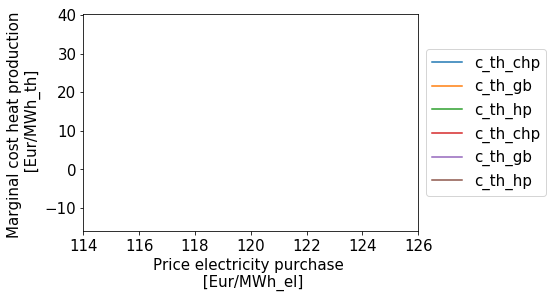

In [20]:
fig, ax = plt.subplots()
plot_lcoh(lcoh_1, ax)
plot_lcoh(lcoh_2, ax)
plt.show()

# New attempt

In [21]:
data_input = pd.read_csv('data_screening_curve.csv')

filename = '/home/jann/Desktop/repos/model_development/System_B/Model_2/results/production_run/data_postprocessed/price_electricity_all.csv'
price_el_all = pd.read_csv(filename, header=[0,1,2,3], index_col=0)
price_el_import = price_el_all.loc[:, (slice(None), ['source_electricity'])]

In [22]:
def calculate(x):
    kwargs = {col: x[col] for col in x.index}
    del kwargs['run_id']
    del kwargs['line_id']
    result = calculate_lcoh(**kwargs)
    result = pd.Series(result)
    return result

data_spec_costs = data_input.apply(calculate, axis=1)

data_all = data_input.merge(data_spec_costs,
                            left_index=True, right_index=True)

data_plot = data_all[['c_el', 'line_id', 'c_th_chp', 'c_th_gb', 'c_th_hp']]\
    .set_index('c_el')

In [23]:
data_plot

,line_id,c_th_chp,c_th_gb,c_th_hp
c_el,,,,
20.0,0,69.024823,37.755102,5.714286
200.0,0,-80.975177,37.755102,57.142857
20.0,1,60.159574,32.653061,5.714286
200.0,1,-89.840426,32.653061,57.142857
20.0,2,77.890071,42.857143,5.714286
200.0,2,-72.109929,42.857143,57.142857
20.0,3,69.024823,37.755102,5.714286
200.0,3,-80.975177,37.755102,57.142857
20.0,4,69.024823,37.755102,8.000000


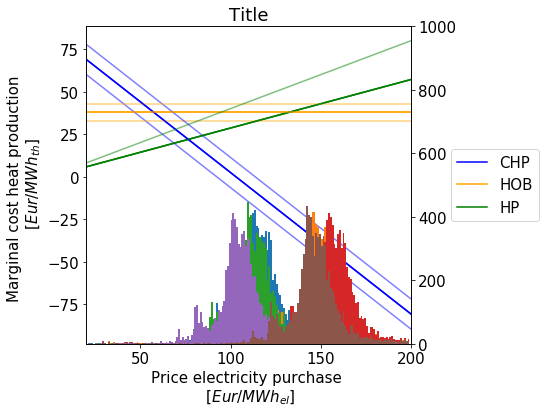

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
rcParams['font.size'] = 15

ax1 = ax.twinx()
for i in range(6):
    ax1.hist(price_el_import.iloc[:, i], bins=np.arange(0, 200, 1))
ax1.set_ylim(0, 1000)

for line_id, group in data_plot.groupby('line_id'):
    alpha = 0.5

    if line_id == 0:
        alpha = 1

    group[['c_th_chp', 'c_th_gb', 'c_th_hp']].plot(
        ax=ax,
        color=['b', 'orange', 'g'],
        label=['c_th_chp', 'c_th_gb', 'c_th_hp'],
        alpha=alpha)


ax.set_title('Title')
# ax.grid(alpha=0.3)
ax.set_xlabel('Price electricity purchase \n $[Eur/MWh_{el}]$')
ax.set_ylabel('Marginal cost heat production \n $[Eur/MWh_{th}]$')
ax.legend(labels=['CHP', 'HOB', 'HP'],
          loc='center left',
          bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()
plt.savefig('pics/screening_curve.pdf', dpi=300)

## Load the model runs to plot their screening curves

In [25]:
filename = '/home/jann/Desktop/repos/model_development/System_B/Model_2/results/production_run'
config_path = '/home/jann/Desktop/repos/model_development/System_B/Model_2/experiment_configs/production_run.yml'

with open(config_path, 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

def load_model_runs(results_dir, cfg):
    model_runs = pd.read_csv(os.path.join(results_dir,
                             'data_preprocessed',
                             cfg['data_preprocessed']['scalars']['model_runs']),
                             index_col=[0, 1, 2], header=[0, 1])
    return model_runs


mr = load_model_runs(filename, cfg=cfg)
mr1 = mr.filter(like='hp-2018_sq', axis=0)
mr1

chp                 \
                                   capacity_installed chp_surcharges   
run_id scenario   uncert_sample_id                                     
0      hp-2018_sq 0                              60.0           31.0   

                                                                          \
                                   efficiency_el efficiency_el_full_cond   
run_id scenario   uncert_sample_id                                         
0      hp-2018_sq 0                         0.47                     0.5   

                                                                  \
                                   efficiency_th    fom lifetime   
run_id scenario   uncert_sample_id                                 
0      hp-2018_sq 0                        0.564  0.023     25.0   

                                                                           \
                                   network_charges_WP overnight_cost  vom   
run_id scenario   uncert_sample_id                                          
0      hp-2018_sq 0                               1.9      1300000.0  4.5   

                                    ... tes_central           tes_decentral  \
                                    ...   rate_loss  vom capacity_installed   
run_id scenario   uncert_sample_id  ...                                       
0      hp-2018_sq 0                 ...       0.001  0.0               14.0   

                                                                               \
                                   efficiency_charging efficiency_discharging   
run_id scenario   uncert_sample_id                                              
0      hp-2018_sq 0                               0.95                   0.95   

                                                                                
                                    fom lifetime overnight_cost rate_loss  vom  
run_id scenario   uncert_sample_id                                              
0      hp-2018_sq 0                 8.6     40.0        14320.0     0.001  0.0  

[1 rows x 127 columns]

In [484]:
def get_lcoh(mr1, spot_price_deviation_from_mean):
    spot_price = mr1['source_electricity', 'spot_price'].squeeze() + spot_price_deviation_from_mean
    eta_th_chp = mr1['chp', 'efficiency_th'].squeeze()
    eta_el_chp = mr1['chp', 'efficiency_el'].squeeze()
    eta_th_gb = mr1['gas_boiler_central', 'efficiency'].squeeze()
    eta_th_hp = mr1['pth_heat_pump_decentral', 'efficiency'].squeeze()

    c_gas_chp = mr1['source_gas', 'carrier_price'].squeeze() + mr1['chp', 'network_charges_WP'].squeeze()
    c_gas_gb = mr1['source_gas', 'carrier_price'].squeeze() + mr1['gas_boiler_central', 'energy_tax'].squeeze() \
                     + mr1['gas_boiler_central','network_charges_WP'].squeeze()
    rev_el = -spot_price- mr1['source_electricity', 'spot_price'].squeeze() - mr1['chp', 'chp_surcharges'].squeeze()
    c_el = spot_price + mr1['source_electricity', 'spot_price'].squeeze() + mr1['source_electricity', 'tax_levys'].squeeze() \
             + mr1['pth_heat_pump_decentral', 'network_charges_WP'].squeeze()
    
    return calculate_lcoh(eta_th_chp, eta_el_chp, eta_th_gb, eta_th_hp, c_gas_chp, c_gas_gb,c_el, rev_el, spot_price)

In [485]:
lcoh = get_lcoh(mr1, 0)
for price in np.arange(-20, 20):
    lcoh = pd.concat([lcoh, get_lcoh(mr1, price)])
lcoh.plot()

TypeError: tuple indices must be integers or slices, not tuple

In [486]:
eta_th_chp = 0.564
eta_el_chp = 0.47
eta_th_gb = 0.98
eta_th_hp = 3.5
c_gas_chp = 30
c_gas_gb = 37
c_el = 50
rev_el = -113
spot_price = 41

lcoh = calculate_lcoh(eta_th_chp,
                      eta_el_chp,
                      eta_th_gb,
                      eta_th_hp,
                      c_gas_chp,
                      c_gas_gb,
                      c_el,
                      rev_el,
                      spot_price)
lcoh

{'c_el': -72,
 'c_th_chp': 134.76950354609932,
 'c_th_gb': 51.02040816326531,
 'c_th_hp': -20.571428571428573}

TypeError: cannot concatenate object of type "<class 'dict'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

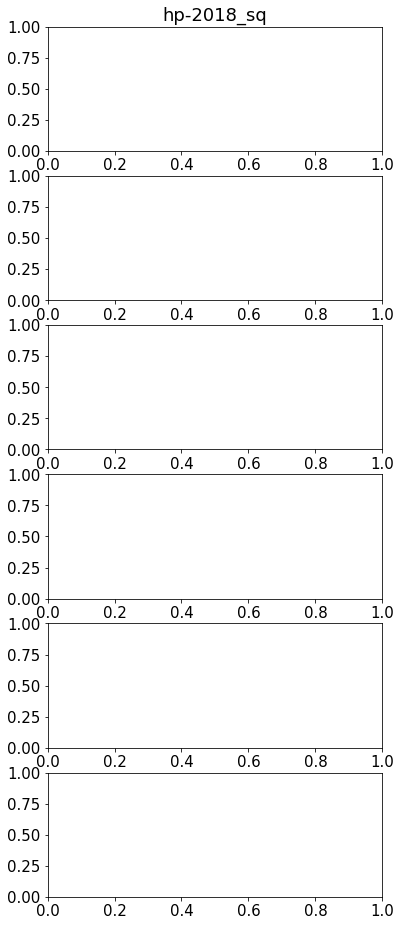

In [487]:
fig, axs = plt.subplots(6, 1, figsize=(6, 16))
i = 0
for mr1 in mr.iterrows():
    if mr1[0][1] in ['hp-2018_sq',
                     'hp-2030_sq',
                     'hp-2050_sq',
                     'hp-2018_ff',
                     'hp-2030_ff',
                     'hp-2050_ff',]:
        axs[i].set_title(mr1[0][1])
        lcoh = get_lcoh(mr1[1], 0)
        for price in np.arange(-100, 100):
            lcoh = pd.concat([lcoh, get_lcoh(mr1[1], price)])
        lcoh.plot(ax=axs[i])
        axs[i].legend().remove()
        i += 1
plt.tight_layout()

# Plot scenario assumptions

Reproduce Marcus' bar chart

In [488]:
filename = '/home/jann/Desktop/repos/model_development/System_B/Model_2/results/production_run'
config_path = '/home/jann/Desktop/repos/model_development/System_B/Model_2/experiment_configs/production_run.yml'

with open(config_path, 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

def load_model_runs(results_dir, cfg):
    model_runs = pd.read_csv(os.path.join(results_dir,
                             'data_preprocessed',
                             cfg['data_preprocessed']['scalars']['model_runs']),
                             index_col=[0, 1, 2], header=[0, 1])
    return model_runs


mr = load_model_runs(filename, cfg=cfg)

In [489]:
param_changing = mr[[col for col in mr.columns if len(mr[col].unique())>1]]
param_changing

gas_boiler_central pth_heat_pump_decentral  \
                                           energy_tax      network_charges_GP   
run_id scenario   uncert_sample_id                                              
0      hp-2018_sq 0                               5.5                     0.0   
       hp-2018_ff 0                               0.0                  6500.0   
       hp-2030_sq 0                               5.5                     0.0   
       hp-2030_ff 0                               0.0                  7172.1   
       hp-2050_sq 0                               5.5                     0.0   
       hp-2050_ff 0                               0.0                  8248.5   

                                                                          \
                                   network_charges_PP network_charges_WP   
run_id scenario   uncert_sample_id                                         
0      hp-2018_sq 0                          22010.00              51.90   
       hp-2018_ff 0                              0.00              18.00   
       hp-2030_sq 0                          24285.83              57.27   
       hp-2030_ff 0                              0.00              19.86   
       hp-2050_sq 0                          27930.69              65.86   
       hp-2050_ff 0                              0.00              22.84   

                                   pth_resistive_central                     \
                                      network_charges_GP network_charges_KP   
run_id scenario   uncert_sample_id                                            
0      hp-2018_sq 0                                 0.00               0.00   
       hp-2018_ff 0                              8160.00           11910.00   
       hp-2030_sq 0                                 0.00               0.00   
       hp-2030_ff 0                              9003.74           13141.49   
       hp-2050_sq 0                                 0.00               0.00   
       hp-2050_ff 0                             10355.04           15113.79   

                                                                          \
                                   network_charges_PP network_charges_WP   
run_id scenario   uncert_sample_id                                         
0      hp-2018_sq 0                          16250.00              37.90   
       hp-2018_ff 0                              0.00               7.00   
       hp-2030_sq 0                          17930.25              41.82   
       hp-2030_ff 0                              0.00               7.72   
       hp-2050_sq 0                          20621.25              48.10   
       hp-2050_ff 0                              0.00               8.88   

                                   pth_resistive_decentral                     \
                                        network_charges_GP network_charges_PP   
run_id scenario   uncert_sample_id                                              
0      hp-2018_sq 0                                    0.0           22010.00   
       hp-2018_ff 0                                 6500.0               0.00   
       hp-2030_sq 0                                    0.0           24285.83   
       hp-2030_ff 0                                 7172.1               0.00   
       hp-2050_sq 0                                    0.0           27930.69   
       hp-2050_ff 0                                 8248.5               0.00   

                                                      source_electricity  \
                                   network_charges_WP  emission_specific   
run_id scenario   uncert_sample_id                                         
0      hp-2018_sq 0                             51.90              0.503   
       hp-2018_ff 0                             18.00              0.503   
       hp-2030_sq 0                             57.27              0.254   
       hp-2030_ff 0                  

In [490]:
param_changing.index #.get_level_values(1).str.split('_')

MultiIndex(levels=[[0], ['hp-2018_ff', 'hp-2018_sq', 'hp-2030_ff', 'hp-2030_sq', 'hp-2050_ff', 'hp-2050_sq'], [0]],
           codes=[[0, 0, 0, 0, 0, 0], [1, 0, 3, 2, 5, 4], [0, 0, 0, 0, 0, 0]],
           names=['run_id', 'scenario', 'uncert_sample_id'])

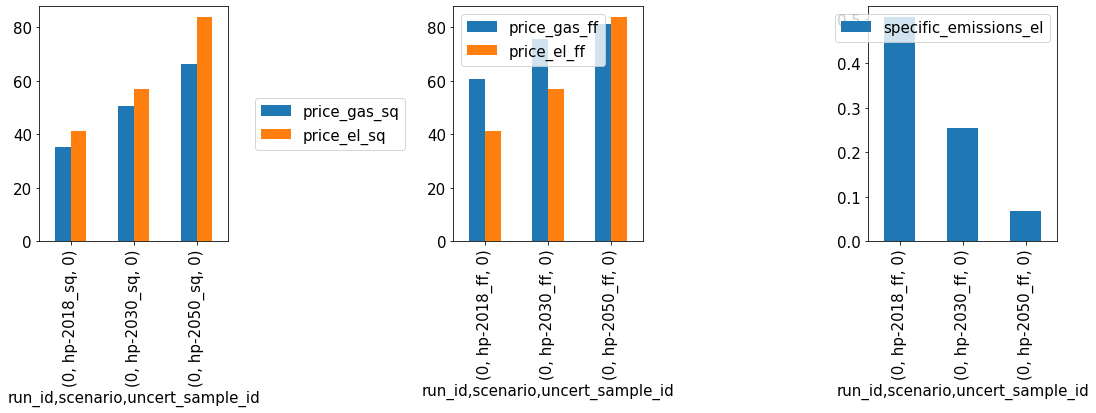

In [491]:
df_sq = pd.DataFrame()
df_ff = pd.DataFrame()
dg = pd.DataFrame()
df_sq['price_gas_sq'] = (
                        param_changing['source_gas', 'carrier_price']
                        + param_changing['source_gas', 'co2_ets']
                        + param_changing['source_gas', 'co2_fee']
                     ).filter(regex='sq', axis=0)

df_ff['price_gas_ff'] = (
                        param_changing['source_gas', 'carrier_price']
                        + param_changing['source_gas', 'co2_ets']
                        + param_changing['source_gas', 'co2_fee']
                     ).filter(regex='ff', axis=0)

df_sq['price_el_sq'] = param_changing['source_electricity', 'spot_price'].filter(regex='sq', axis=0)
df_ff['price_el_ff'] = param_changing['source_electricity', 'spot_price'].filter(regex='ff', axis=0)

df_emissions = pd.DataFrame()
dg['specific_emissions_el'] = param_changing['source_electricity', 'emission_specific'].filter(regex='ff', axis=0)

fig, axs = plt.subplots(1, 3, figsize=(15,6))
df_sq.plot.bar(ax=axs[0])
df_ff.plot.bar(ax=axs[1])
dg.plot.bar(ax=axs[2])
axs[0].legend(
          # labels=[],
          loc='center left',
          bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()

In [492]:
def plot_clustered_stacked(ax, df_all, yerrs=None, colors=None, labels=None,
                           title="multiple stacked bar plot",  H="/", **kwargs):
    r"""
    Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
    labels is a list of the names of the dataframe, used for the legend
    title is a string for the title of the plot
    H is the hatch used for identification of the different dataframe
    """
    n_df = len(df_all)
    n_col = []
    n_ind = len(df_all[0].index)
    
    for i, df in enumerate(df_all):  # for each data frame
        n_col.append(len(df.columns))
        ax = df.plot(kind="bar",
                     linewidth=0,
                     stacked=True,
                     ax=ax,
                     color=colors[i],
                     legend=False,
                     grid=False,
                     **kwargs)  # make bar plots


    h, l = ax.get_legend_handles_labels()  # get the handles we want to modify
    for k, n in enumerate(n_col):
        i = sum(n_col[:k])
        for j, pa in enumerate(h[i:i+n]):
            for rect in pa.patches:  # for each index
                width = 1 / (1.2*float(n_df + 2))
                rect.set_x(rect.get_x() + 1 / float(n_df + 2) * i / float(n_df)) 
                rect.set_width(width)
                
    if yerrs is not None:
        for i, yerr in enumerate(yerrs):
            ax.errorbar([item - 1 / (float(n_df + 2)) + width/2 for item in [0,1,2]],
                        [30,30,40], yerr=[[10, 10, 10], [5, 5, 5]])
           
    ax.set_xticks((np.arange(0, 2 * n_ind, 2) - (1 / (float(n_df + 2)) - width)) / 2.)
    
    if labels==None:
        ax.set_xticklabels(df.index, rotation = 0)
    else:
        ax.set_xticklabels(labels, rotation = 0)
        
    ax.set_title(title)
    
    return ax

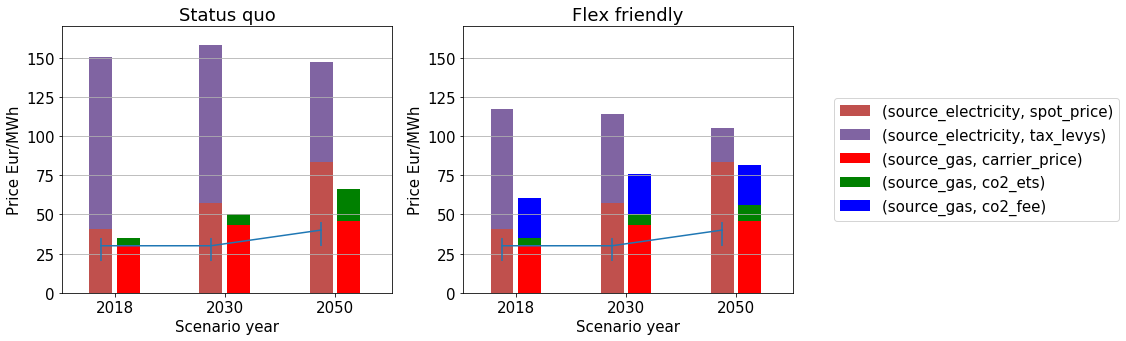

In [493]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
df1 = param_changing.loc[:, ('source_electricity', ['spot_price', 'tax_levys'])]
df2 = param_changing.loc[:, ('source_gas', ['carrier_price', 'co2_ets', 'co2_fee'])]

axs[0] = plot_clustered_stacked(axs[0],
    [df1.filter(regex='sq', axis=0),
    df2.filter(regex='sq', axis=0)],
    yerrs=[0],
    colors=[['#c0504d', '#8064a2', '#4f81bd'],['r','g','b']],
    labels=[2018, 2030, 2050],
    title='Status quo')

axs[1] = plot_clustered_stacked(axs[1],
    [df1.filter(regex='ff', axis=0),
     df2.filter(regex='ff', axis=0)],
    yerrs=[0],
    colors=[['#c0504d', '#8064a2', '#4f81bd'],['r','g','b']],
    labels=[2018, 2030, 2050],
    title='Flex friendly')

for ax in axs:
    ax.grid(axis='y')
    ax.set_ylabel('Price Eur/MWh')
    ax.set_xlabel('Scenario year')
    ax.set_ylim(0, 170)
    
axs[1].legend(
      # labels=[],
      loc='center left',
      bbox_to_anchor=(1.1, 0.5))

plt.tight_layout()
plt.savefig('pics/energy_carrier_prices.pdf')

# uncertainty

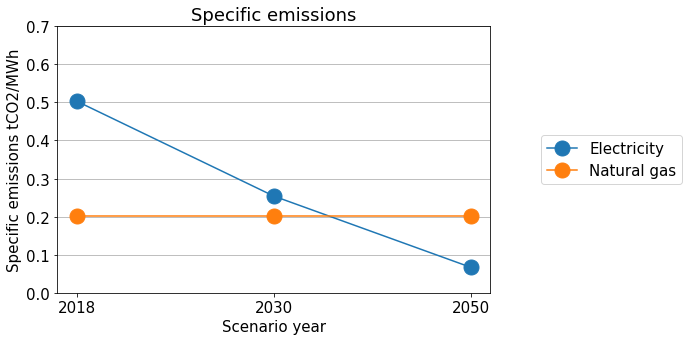

In [494]:
fig, ax = plt.subplots(figsize=(10, 5))
df = mr.loc[:, (slice(None), 'emission_specific')].filter(regex='sq', axis=0)
df.index = ['2018', '2030', '2050']
df.columns = df.columns.droplevel(1)

ax.plot(df,
        marker='.',
        markersize=30)

ax.set_title('Specific emissions')
ax.grid(axis='y')
ax.set_ylabel('Specific emissions tCO2/MWh')
ax.set_xlabel('Scenario year')
ax.set_ylim(0, 0.7)

ax.legend(
      labels=['Electricity', 'Natural gas'],
      loc='center left',
      bbox_to_anchor=(1.1, 0.5))

plt.tight_layout()
plt.savefig('pics/specific_emissions.pdf')

# uncertainty

# Plot derived metrics

In [3]:
filename = '/home/jann/Desktop/repos/model_development/System_B/Model_2/results/production_run/data_postprocessed/results_scalar_derived_all.csv'
results_scalar_derived_all = pd.read_csv(filename, index_col=[0,1,2,3,4])


In [4]:


fig = plt.figure(figsize=(12,6))

gs = plt.GridSpec(2, 2)

axs[] = fig.add_subplot(gs[, :])

SyntaxError: invalid syntax (<ipython-input-4-aa2ae8492068>, line 7)

In [5]:
idx = pd.IndexSlice

energy_produced_sum = results_scalar_derived_all\
    .loc[idx[:,:,:,:, ['energy_thermal_produced_sum', 'energy_electricity_produced_sum']], :]
energy_produced_sum = energy_produced_sum.loc[energy_produced_sum['var_value']!=0]

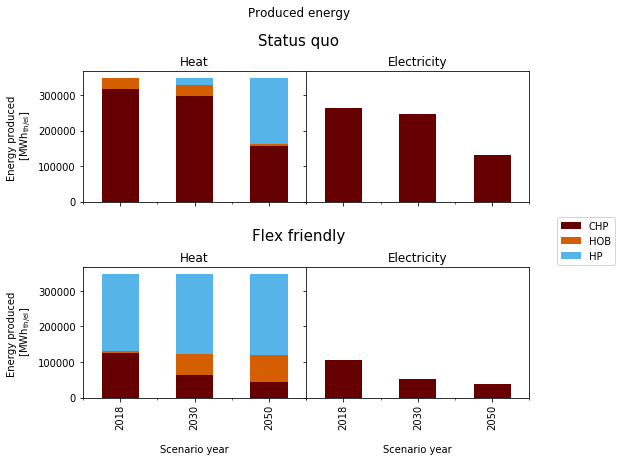

In [6]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,6))

for i, scenario_regulatory in enumerate(['sq', 'ff']):
    for j, item in enumerate(['energy_thermal_produced_sum', 'energy_electricity_produced_sum']):
        df_plot = energy_produced_sum\
            .filter(regex=scenario_regulatory, axis=0)['var_value']
        labels = [label_dict[item] for item in df_plot.index.get_level_values(3).unique()]
        colors = [color_dict[item] for item in df_plot.index.get_level_values(3).unique()]
        df_plot.unstack().unstack()\
            [item]\
            .plot.bar(ax=axs[i][j],
                stacked=True,
                color=colors,
                label=labels)

for i, ax in enumerate(axs[0]):
    ax.set_ylabel('Energy produced \n $\mathregular{[MWh_{th/el}]}$')
    ax.set_title(['Heat', 'Electricity'][i])

for i, ax in enumerate(axs[1]):
    ax.set_xlabel('Scenario year', labelpad=15)
    ax.set_xticklabels(['2018', '2030', '2050'])
    ax.set_ylabel('Energy produced \n $\mathregular{[MWh_{th/el}]}$')
    ax.set_title(['Heat', 'Electricity'][i])
    
for ax in axs.flatten():
    ax.legend().remove()

# labels = label_dict
axs[0,1].legend(labels, loc='center left', bbox_to_anchor=(1.1, -0.3))

fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0.5)
plt.figtext(0.5, 0.95, 'Status quo', fontsize=15, ha='center', va='center')
plt.figtext(0.5, 0.5, 'Flex friendly', fontsize=15, ha='center', va='center')
plt.suptitle('Produced energy', x=0.5, y=1.03)

plt.savefig('pics/produced_energy.pdf' ,bbox_inches='tight')

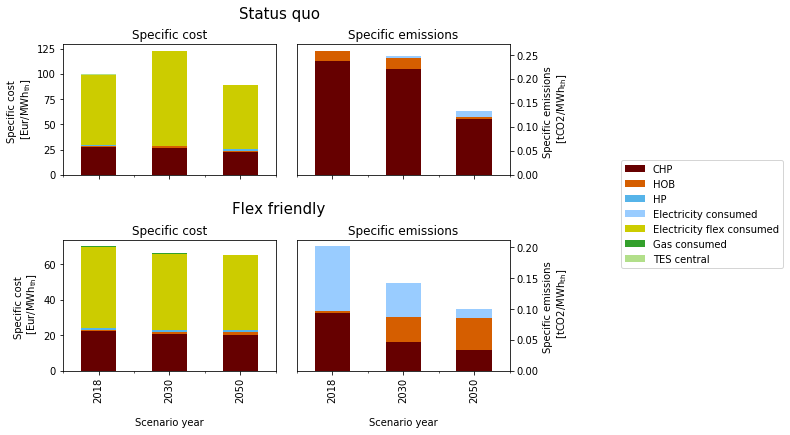

In [7]:
costs_and_emissions = results_scalar_derived_all\
    .loc[idx[:,:,:,:, ['cost_specific_heat', 'emissions_specific_heat']], :]
costs_and_emissions = costs_and_emissions.loc[costs_and_emissions['var_value']!=0]

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8,6))

for i, scenario_regulatory in enumerate(['sq', 'ff']):
    for j, item in enumerate(['cost_specific_heat', 'emissions_specific_heat']):
        df_plot = costs_and_emissions\
            .filter(regex=scenario_regulatory, axis=0)['var_value']
        labels = [label_dict[item] for item in df_plot.index.get_level_values(3).unique()]
        colors = [color_dict[item] for item in df_plot.index.get_level_values(3).unique()]
        df_plot.unstack().unstack()\
            [item]\
            .plot.bar(ax=axs[i][j],
                stacked=True,
                color=colors,
                label=labels)

for i in range(2):
    axs[i,1].yaxis.set_label_position("right")
    axs[i,1].yaxis.tick_right()

    axs[i,0].set_ylabel('Specific cost \n $\mathregular{[Eur/MWh_{th}]}$')
    axs[i,1].set_ylabel('Specific emissions \n $\mathregular{[tCO2/MWh_{th}]}$')
    
    for ax in axs[:,i]:
        ax.set_title(['Specific cost', 'Specific emissions'][i])
    
    for ax in axs[1,:]:
        ax.set_xlabel('Scenario year', labelpad=15)
        ax.set_xticklabels(['2018', '2030', '2050'])
    
for ax in axs.flatten():
    ax.legend().remove()
    
axs[0,1].legend(labels, loc='center left', bbox_to_anchor=(1.5, -0.3))

fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.5)
plt.figtext(0.5, 0.95, 'Status quo', fontsize=15, ha='center', va='center')
plt.figtext(0.5, 0.5, 'Flex friendly', fontsize=15, ha='center', va='center')
# plt.suptitle('Produced energy', x=0.5, y=1.03)

plt.savefig('pics/costs_and_emissions.pdf' ,bbox_inches='tight')

In [13]:
costs_and_emissions.loc[idx[:,:,:,:,'cost_specific_heat'], :]

var_unit  \
run_id scenario   uncert_sample_id component               var_name                      
0      hp-2018_sq 0                chp                     cost_specific_heat  Eur/MWh   
                                   gas_boiler_central      cost_specific_heat  Eur/MWh   
                                   pth_heat_pump_decentral cost_specific_heat      NaN   
                                   source_gas              cost_specific_heat  Eur/MWh   
                                   tes_central             cost_specific_heat  Eur/MWh   
                                   tes_decentral           cost_specific_heat      NaN   
       hp-2018_ff 0                chp                     cost_specific_heat  Eur/MWh   
                                   gas_boiler_central      cost_specific_heat  Eur/MWh   
                                   pth_heat_pump_decentral cost_specific_heat      NaN   
                                   source_gas              cost_specific_heat  Eur/MWh   
                                   tes_central             cost_specific_heat  Eur/MWh   
                                   tes_decentral           cost_specific_heat      NaN   
       hp-2030_sq 0                chp                     cost_specific_heat  Eur/MWh   
                                   gas_boiler_central      cost_specific_heat  Eur/MWh   
                                   pth_heat_pump_decentral cost_specific_heat      NaN   
                                   source_gas              cost_specific_heat  Eur/MWh   
                                   tes_central             cost_specific_heat  Eur/MWh   
                                   tes_decentral           cost_specific_heat      NaN   
       hp-2030_ff 0                chp                     cost_specific_heat  Eur/MWh   
                                   gas_boiler_central      cost_specific_heat  Eur/MWh   
                                   pth_heat_pump_decentral cost_specific_heat      NaN   
                                   source_gas              cost_specific_heat  Eur/MWh   
                                   tes_central             cost_specific_heat  Eur/MWh   
                                   tes_decentral           cost_specific_heat      NaN   
       hp-2050_sq 0                chp                     cost_specific_heat  Eur/MWh   
                                   gas_boiler_central      cost_specific_heat  Eur/MWh   
                                   pth_heat_pump_decentral cost_specific_heat      NaN   
                                   source_gas              cost_specific_heat  Eur/MWh   
                                   tes_central             cost_specific_heat  Eur/MWh   
                                   tes_decentral           cost_specific_heat      NaN   
       hp-2050_ff 0                chp                     cost_specific_heat  Eur/MWh   
                                   gas_boiler_central      cost_specific_heat  Eur/MWh   
                                   pth_heat_pump_decentral cost_specific_heat      NaN   
                                   source_gas              cost_specific_heat  Eur/MWh   
                                   tes_central             cost_specific_heat  Eur/MWh   
                                   tes_decentral           cost_specific_heat      NaN   

                                                                               var_value  
run_id scenario   uncert_sample_id component               var_name                       
0      hp-2018_sq 0                chp                     cost_specific_heat  27.155753  
                                   gas_boiler_central      cost_specific_heat   1.742044  
                                   pth_heat_pump_decentral cost_specific_heat   0.215888  
                                   source_gas              cost_specific_heat  69.938701  
                                   tes_central             cost_specific_heat   0.252160  
                    

In [555]:
costs_and_emissions.filter(regex='sq', axis=0)

var_unit  \
run_id scenario   uncert_sample_id component               var_name                              
0      hp-2018_sq 0                chp                     cost_specific_heat          Eur/MWh   
                                                           emissions_specific_heat  tCO2/MW_th   
                                   gas_boiler_central      cost_specific_heat          Eur/MWh   
                                                           emissions_specific_heat  tCO2/MW_th   
                                   pth_heat_pump_decentral cost_specific_heat              NaN   
                                   source_electricity      emissions_specific_heat  tCO2/MW_th   
                                   source_gas              cost_specific_heat          Eur/MWh   
                                   tes_central             cost_specific_heat          Eur/MWh   
                                   tes_decentral           cost_specific_heat              NaN   
       hp-2030_sq 0                chp                     cost_specific_heat          Eur/MWh   
                                                           emissions_specific_heat  tCO2/MW_th   
                                   gas_boiler_central      cost_specific_heat          Eur/MWh   
                                                           emissions_specific_heat  tCO2/MW_th   
                                   pth_heat_pump_decentral cost_specific_heat              NaN   
                                   source_electricity      emissions_specific_heat  tCO2/MW_th   
                                   source_gas              cost_specific_heat          Eur/MWh   
                                   tes_central             cost_specific_heat          Eur/MWh   
                                   tes_decentral           cost_specific_heat              NaN   
       hp-2050_sq 0                chp                     cost_specific_heat          Eur/MWh   
                                                           emissions_specific_heat  tCO2/MW_th   
                                   gas_boiler_central      cost_specific_heat          Eur/MWh   
                                                           emissions_specific_heat  tCO2/MW_th   
                                   pth_heat_pump_decentral cost_specific_heat              NaN   
                                   source_electricity      emissions_specific_heat  tCO2/MW_th   
                                   source_gas              cost_specific_heat          Eur/MWh   
                                   tes_central             cost_specific_heat          Eur/MWh   
                                   tes_decentral           cost_specific_heat              NaN   

                                                                                    var_value  
run_id scenario   uncert_sample_id component               var_name                            
0      hp-2018_sq 0                chp                     cost_specific_heat       27.155753  
                                                           emissions_specific_heat   0.237482  
                                   gas_boiler_central      cost_specific_heat        1.742044  
                                                           emissions_specific_heat   0.020812  
                                   pth_heat_pump_decentral cost_specific_heat        0.215888  
                                   source_electricity      emissions_specific_heat   0.000811  
                                   source_gas              cost_specific_heat       69.938701  
                                   tes_central             cost_specific_heat        0.252160  
                                   tes_decentral           cost_specific_heat        0.040418  
       hp-2030_sq 0                chp                     cost_specific_heat       26.601810  
                                                           emissions_specific_heat   0.2214

In [537]:
em_sum = results_scalar_derived_all  \
    .loc[idx[:,:,:,:, ['emissions_sum']], :]
for scenario, group in em_sum.groupby('scenario'):
    print(scenario)
    g_sum = group.aggregate(sum)
    print(g_sum['var_value']/350000)

hp-2018_ff
0.22115888959159527
hp-2018_sq
0.344234341447567
hp-2030_ff
0.14545739494262014
hp-2030_sq
0.32692096825640327
hp-2050_ff
0.10259663811481569
hp-2050_sq
0.1743688722125768


In [538]:
cost = results_scalar_derived_all  \
    .loc[idx[:,:,:,:, ['cost_specific_heat']], :]
cost

var_unit  \
run_id scenario   uncert_sample_id component var_name                      
0      hp-2018_sq 0                demand_th cost_specific_heat  Eur/MWh   
       hp-2018_ff 0                demand_th cost_specific_heat  Eur/MWh   
       hp-2030_sq 0                demand_th cost_specific_heat  Eur/MWh   
       hp-2030_ff 0                demand_th cost_specific_heat  Eur/MWh   
       hp-2050_sq 0                demand_th cost_specific_heat  Eur/MWh   
       hp-2050_ff 0                demand_th cost_specific_heat  Eur/MWh   

                                                                  var_value  
run_id scenario   uncert_sample_id component var_name                        
0      hp-2018_sq 0                demand_th cost_specific_heat  101.139100  
       hp-2018_ff 0                demand_th cost_specific_heat   76.393068  
       hp-2030_sq 0                demand_th cost_specific_heat  125.737003  
       hp-2030_ff 0                demand_th cost_specific_heat   73.007332  
       hp-2050_sq 0                demand_th cost_specific_heat  101.835777  
       hp-2050_ff 0                demand_th cost_specific_heat   72.644901

# Test emissions allocation

In [64]:
from src.postprocess import allocate_emissions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
em_dict = {}

for method in ['iea', 'efficiency', 'finnish']:
    em_dict[method] = allocate_emissions(
        total_emissions=200,
        eta_el=0.3,
        eta_th=0.5,
        method=method,
        eta_el_ref=0.525,
        eta_th_ref=0.82
    )
    
pd.DataFrame.from_dict(em_dict,
                       orient='index',
                       columns=['emissions allocated to electricity', 'emissions allocated to heat'])

,emissions allocated to electricity,emissions allocated to heat
iea,75.000000,125.000000
efficiency,125.000000,75.000000
finnish,96.755162,103.244838


# UA


In [105]:
input_data = pd.read_csv('../data/parameter_v0-7.csv', delimiter=';', index_col=0)

In [106]:
df = input_data[['scenario', 'uncertainty', 'var_name', 'var_value', 'var_unit']]  \
    .set_index(['scenario', 'uncertainty', 'var_name'], drop=True)

In [107]:
uncertain_variables = df.loc[df.index.get_level_values(1)=='high'].index.get_level_values(2)
uncertain_variables

Index(['factor_load_reduction_heat', 'factor_load_reduction_heat',
       'spot_price', 'tax_levys', 'tax_levys', 'carrier_price',
       'factor_load_reduction_heat', 'spot_price', 'tax_levys', 'tax_levys',
       'carrier_price', 'factor_load_reduction_heat', 'spot_price',
       'tax_levys', 'tax_levys', 'carrier_price', 'factor_load_reduction_heat',
       'spot_price', 'tax_levys', 'tax_levys', 'carrier_price',
       'factor_load_reduction_heat'],
      dtype='object', name='var_name')

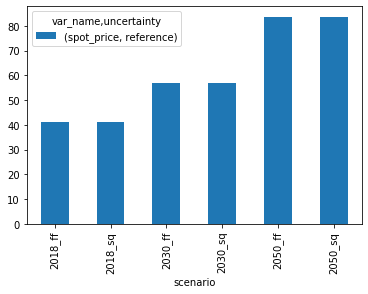

In [237]:
df_uncertain = df.loc[df.index.get_level_values(2).isin(uncertain_variables)]
df_uncertain.loc[: ,'var_value'] = df_uncertain.loc[:, 'var_value'].astype(float)
fig, ax = plt.subplots()
df_uncertain.loc[idx[:,'reference','spot_price'],:]['var_value']  \
    .unstack().unstack()  \
    .plot.bar(ax=ax, stacked=True)

ref = df_uncertain.loc[idx[:,'reference','spot_price'],:]['var_value']
high = df_uncertain.loc[idx[:,'high','spot_price'],:]['var_value']  
low = df_uncertain.loc[idx[:,'low','spot_price'],:]['var_value']  

ref.index = ref.index.droplevel(1)
high.index = high.index.droplevel(1)
low.index = low.index.droplevel(1)

In [239]:
high-ref

scenario  var_name  
2018_ff   spot_price      NaN
2018_sq   spot_price      NaN
2030_ff   spot_price     4.00
2030_sq   spot_price     4.00
2050_ff   spot_price    10.66
2050_sq   spot_price    10.66
Name: var_value, dtype: float64

In [240]:
ref-low

scenario  var_name  
2018_ff   spot_price      NaN
2018_sq   spot_price      NaN
2030_ff   spot_price     4.00
2030_sq   spot_price     4.00
2050_ff   spot_price    10.67
2050_sq   spot_price    10.67
Name: var_value, dtype: float64

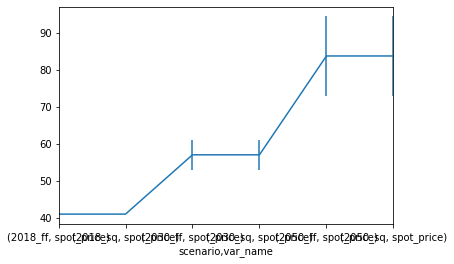

In [241]:
ref.plot(yerr=[ref-low, high -ref])